<a href="https://colab.research.google.com/github/TheCaveOfAdullam/2026-reserch-1/blob/main/A_11kw_TestChPrune_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_pruning
!pip install ptflops
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=5db5660e3c75daca0a70279f1ba6b3f2e370669d37a2c3543d0cd6e4c84f89e7
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=406e3a5681cac505e1912a85dd5f61c2631cd534d519771d612f60070fbf4703
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [ ]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F # 추가됨.
import torch.optim as optim
import torch_pruning as tp
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import time

In [ ]:
seed = 62
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # GPU 사용 시
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM', 'fault_BELT']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== 저장된 데이터 로딩용 Dataset =====
class PreprocessedDataset(Dataset):
    def __init__(self, pt_file):
        data = torch.load(pt_file, weights_only=False)
        self.X = data['X']
        self.y = data['y']

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].T
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# ===== CSV 읽기 없이 바로 로딩 =====
train_dataset = PreprocessedDataset('/content/drive/MyDrive/11kw pro data/train_processed.pt')
val_dataset   = PreprocessedDataset('/content/drive/MyDrive/11kw pro data/val_processed.pt')
test_dataset  = PreprocessedDataset('/content/drive/MyDrive/11kw pro data/test_processed.pt')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

print("빠른 데이터 로딩 완료!")

빠른 데이터 로딩 완료!


In [ ]:
# 첫 번째 데이터의 크기를 이용해 input_length 결정
first_sample, _ = train_dataset[0]
input_length = first_sample.shape[1]  # X는 (채널, 길이) 형태이므로 길이는 첫 번째 데이터의 두 번째 차원
print(f"Input length for one sample: {input_length}")

Input length for one sample: 1500


In [ ]:
# CNN 모델 정의
class CNNModel(nn.Module):
    def __init__(self, input_length):
        super(CNNModel, self).__init__()

        # --- Convolution layers ---
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # --- Flatten 후 크기 계산 ---
        with torch.no_grad():
            sample_input = torch.zeros(1, 1, input_length)
            sample_output = self.forward_conv_layers(sample_input)
            conv_output_size = sample_output.size(1) * sample_output.size(2)

        # --- Fully Connected ---
        self.fc1 = nn.Linear(conv_output_size, 256)
        self.dropout = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, len(categories))

    def forward_conv_layers(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self.forward_conv_layers(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.bn1(x)
        x = self.fc2(x)
        return x

In [ ]:
# 모델 학습 함수 (학습 곡선 기록 추가)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, max_norm=1.0):
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # 학습 곡선 시각화
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return model

# 모델 평가 함수
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 샘플 수 기반의 loss 계산
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 전체 샘플 수로 나눔 → 샘플 평균 Loss
    average_val_loss = val_loss / total
    val_accuracy = 100 * correct / total

    return average_val_loss, val_accuracy


In [ ]:
def calculate_mean_gradients(model, dataloader, device, criterion):
    mean_gradients = {}
    model.train()  # 기울기 계산을 위해 train 모드로 설정

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d):
            # 기울기를 저장할 리스트 초기화
            channel_gradients = []

            def hook_fn(grad):
                # 채널별로 기울기의 절댓값 평균을 계산하여 저장
                grad = grad.detach().cpu().numpy()
                channel_mean_grad = np.mean(np.abs(grad), axis=(1, 2))
                channel_gradients.append(channel_mean_grad)

            # 가중치에 대한 hook 등록
            hook = module.weight.register_hook(hook_fn)

            # 데이터셋에 대한 순전파 및 역전파 수행
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                model.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()

            # hook 제거
            hook.remove()

            # 채널별 평균 기울기 계산
            mean_gradient = np.mean(channel_gradients, axis=0)
            mean_gradients[name] = mean_gradient

    return mean_gradients

In [ ]:
def prune_model_based_on_mean_gradient(model, mean_gradients, prune_ratio=0.2, example_inputs=None):
    device = next(model.parameters()).device
    if example_inputs is None:
        example_inputs = torch.randn(1, 1, input_length).to(device)  # 입력 채널을 1로 설정

    DG = tp.DependencyGraph().build_dependency(model, example_inputs=example_inputs)
    total_pruned = 0

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d):
            # 출력 레이어는 프루닝 대상에서 제외 (필요에 따라 수정)
            if name == 'fc3':
                print(f"Skipping pruning for {name} (output layer).")
                continue

            # 채널별 Mean Gradient 가져오기
            if name in mean_gradients:
                channel_mean_grad = mean_gradients[name]
            else:
                continue  # 해당 레이어의 기울기를 계산하지 않았다면 스킵

            # 프루닝할 채널 수 계산
            num_channels = len(channel_mean_grad)
            num_prune = int(num_channels * prune_ratio)
            if num_prune < 1:
                continue  # 프루닝할 채널이 없으면 스킵

            # 중요도가 낮은 채널의 인덱스 선택
            prune_indices = np.argsort(channel_mean_grad)[:num_prune]

            # 프루닝 대상 채널 제거
            if len(prune_indices) > 0 and len(prune_indices) < num_channels:
                pruning_group = DG.get_pruning_group(module, tp.prune_conv_out_channels, idxs=prune_indices)

                if DG.check_pruning_group(pruning_group):
                    pruning_group.prune()
                    total_pruned += len(prune_indices)
                    print(f"Pruned {len(prune_indices)} channels from {name}.")
                else:
                    print(f"Cannot prune {name} due to dependency constraints.")
            else:
                print(f"Skipping pruning for {name} as it would remove all channels.")

    print(f"Mean Gradient-based pruning applied. {total_pruned} channels pruned in total.")
    return model

In [ ]:
# 모델 초기화 및 학습 설정
model = CNNModel(input_length=input_length)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)

Epoch 1/5: 100%|██████████| 2625/2625 [00:20<00:00, 126.80batch/s, accuracy=60.4, loss=0.859]


Epoch [1/5], Loss: 1.1005, Accuracy: 60.45%, Val Loss: 1.0607, Val Accuracy: 65.61%


Epoch 2/5: 100%|██████████| 2625/2625 [00:18<00:00, 142.57batch/s, accuracy=88.1, loss=0.785]


Epoch [2/5], Loss: 0.8036, Accuracy: 88.12%, Val Loss: 0.8451, Val Accuracy: 76.73%


Epoch 3/5: 100%|██████████| 2625/2625 [00:18<00:00, 140.15batch/s, accuracy=90.8, loss=0.399]


Epoch [3/5], Loss: 0.5384, Accuracy: 90.80%, Val Loss: 0.6439, Val Accuracy: 87.28%


Epoch 4/5: 100%|██████████| 2625/2625 [00:18<00:00, 138.31batch/s, accuracy=94.8, loss=0.365]


Epoch [4/5], Loss: 0.3909, Accuracy: 94.83%, Val Loss: 0.5656, Val Accuracy: 87.01%


Epoch 5/5: 100%|██████████| 2625/2625 [00:18<00:00, 139.63batch/s, accuracy=97.7, loss=0.274]


Epoch [5/5], Loss: 0.2899, Accuracy: 97.71%, Val Loss: 0.5092, Val Accuracy: 84.63%


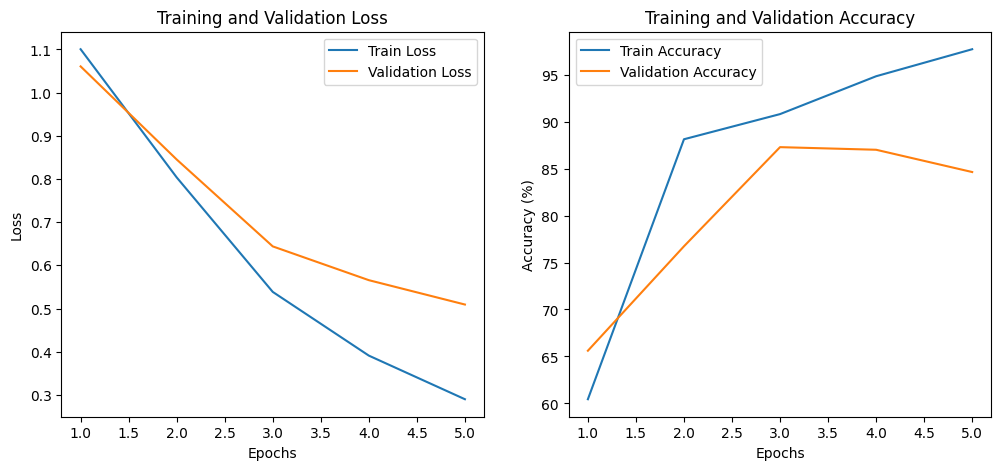

CNNModel(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11968, out_features=256, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

In [ ]:
# Mean Gradient 계산
mean_gradients = calculate_mean_gradients(model, train_loader, device, criterion)

In [ ]:
# 입력 예제 생성 (입력 채널 수와 길이에 맞게 수정)
input_channels = 1  # 모델의 입력 채널 수에 맞게 설정
input_length = 1500  # 입력 데이터의 길이에 맞게 설정
example_inputs = torch.randn(1, input_channels, input_length).to(device)

In [ ]:
# 모델 프루닝
prune_ratio = 0.4  # 프루닝할 비율 (예: 20%)
model = prune_model_based_on_mean_gradient(model, mean_gradients, prune_ratio, example_inputs)

Pruned 6 channels from conv1.
Pruned 12 channels from conv2.
Pruned 25 channels from conv3.
Mean Gradient-based pruning applied. 43 channels pruned in total.


In [ ]:
# 프루닝 후 모델을 디바이스로 이동
model.to(device)

CNNModel(
  (conv1): Conv1d(1, 10, kernel_size=(3,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(10, 20, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(20, 39, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7293, out_features=256, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)

In [ ]:
# 옵티마이저 재설정
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)

Epoch 1/10: 100%|██████████| 2625/2625 [00:16<00:00, 156.09batch/s, accuracy=93.4, loss=0.517]


Epoch [1/10], Loss: 0.5097, Accuracy: 93.42%, Val Loss: 0.5522, Val Accuracy: 90.41%


Epoch 2/10: 100%|██████████| 2625/2625 [00:18<00:00, 139.76batch/s, accuracy=98.4, loss=0.311]


Epoch [2/10], Loss: 0.3242, Accuracy: 98.36%, Val Loss: 0.4582, Val Accuracy: 89.67%


Epoch 3/10: 100%|██████████| 2625/2625 [00:16<00:00, 155.90batch/s, accuracy=99.1, loss=0.146]


Epoch [3/10], Loss: 0.2128, Accuracy: 99.11%, Val Loss: 0.2812, Val Accuracy: 97.48%


Epoch 4/10: 100%|██████████| 2625/2625 [00:16<00:00, 155.01batch/s, accuracy=99.3, loss=0.0879]


Epoch [4/10], Loss: 0.1372, Accuracy: 99.35%, Val Loss: 0.4091, Val Accuracy: 84.23%


Epoch 5/10: 100%|██████████| 2625/2625 [00:17<00:00, 150.67batch/s, accuracy=99.5, loss=0.0575]


Epoch [5/10], Loss: 0.0921, Accuracy: 99.47%, Val Loss: 0.2852, Val Accuracy: 91.41%


Epoch 6/10: 100%|██████████| 2625/2625 [00:17<00:00, 154.14batch/s, accuracy=99.6, loss=0.0506]


Epoch [6/10], Loss: 0.0646, Accuracy: 99.60%, Val Loss: 0.1789, Val Accuracy: 95.78%


Epoch 7/10: 100%|██████████| 2625/2625 [00:17<00:00, 153.39batch/s, accuracy=99.6, loss=0.018]


Epoch [7/10], Loss: 0.0491, Accuracy: 99.61%, Val Loss: 0.1553, Val Accuracy: 96.08%


Epoch 8/10: 100%|██████████| 2625/2625 [00:17<00:00, 154.09batch/s, accuracy=99.7, loss=0.00953]


Epoch [8/10], Loss: 0.0377, Accuracy: 99.66%, Val Loss: 0.1721, Val Accuracy: 94.74%


Epoch 9/10: 100%|██████████| 2625/2625 [00:16<00:00, 154.76batch/s, accuracy=99.7, loss=0.0301]


Epoch [9/10], Loss: 0.0304, Accuracy: 99.71%, Val Loss: 0.1838, Val Accuracy: 94.84%


Epoch 10/10: 100%|██████████| 2625/2625 [00:17<00:00, 154.14batch/s, accuracy=99.7, loss=0.0204]


Epoch [10/10], Loss: 0.0251, Accuracy: 99.73%, Val Loss: 0.1925, Val Accuracy: 93.97%


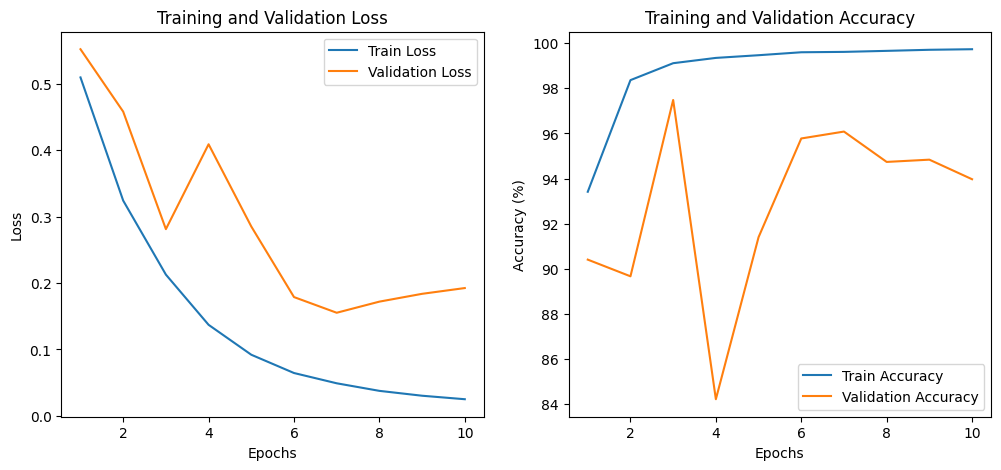

CNNModel(
  (conv1): Conv1d(1, 10, kernel_size=(3,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(10, 20, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(20, 39, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7293, out_features=256, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)

In [ ]:
# 파인튜닝 실행
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

In [ ]:
# 최종 테스트 평가
print("Final evaluation on the test set...")
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

Final evaluation on the test set...
Final Test Loss: 0.1590, Final Test Accuracy: 95.62%


In [ ]:
model.eval()

CNNModel(
  (conv1): Conv1d(1, 10, kernel_size=(3,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(10, 20, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(20, 39, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7293, out_features=256, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)

In [ ]:
# 최종 테스트 평가
print("Final evaluation on the test set...")
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

Final evaluation on the test set...
Final Test Loss: 0.1590, Final Test Accuracy: 95.62%


In [ ]:
# 모델 평가 함수 (혼동 행렬 포함)
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 샘플 수 기반 loss 누적
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    accuracy = 100 * correct / total

    # 전체 샘플 수로 나누기
    return val_loss / total, accuracy, conf_matrix

In [ ]:


# 평가 및 시각화 예시
test_loss, test_accuracy, test_conf_matrix = evaluate_model(model, test_loader, criterion)
print(f"test Loss: {test_loss:.4f}")
print(f"test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
print(test_conf_matrix)

test Loss: 0.1590
test Accuracy: 95.62%
Confusion Matrix:
[[3600    0    0    0    0]
 [   0 2818   77  704    1]
 [   0    0 3595    1    4]
 [   0    0    0 3600    0]
 [   0    0    0    1 3599]]


In [ ]:
# 혼동 행렬 시각화
def plot_confusion_matrix(conf_matrix, label_encoder, title="Confusion Matrix"):
    categories = label_encoder.classes_
    plt.figure(figsize=(7, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=categories, yticklabels=categories,
                linewidths=0.5, linecolor='gray')

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

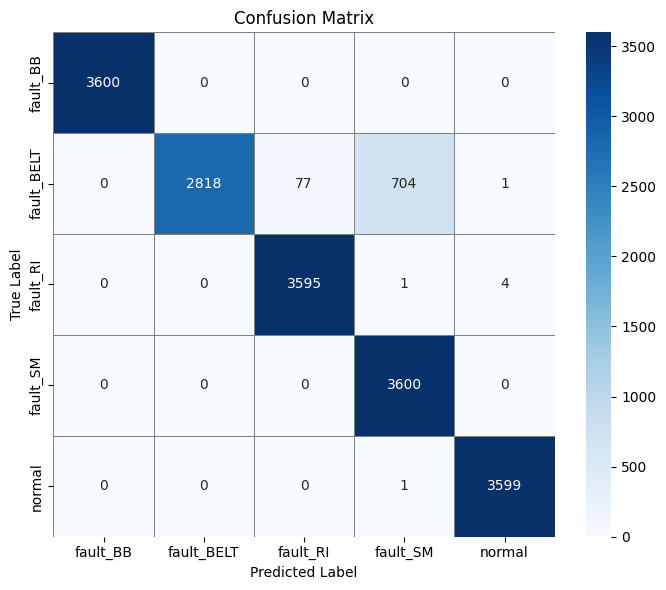

In [ ]:
# 혼동 행렬 시각화
label_encoder = LabelEncoder()
label_encoder.fit(categories)
plot_confusion_matrix(test_conf_matrix, label_encoder)

In [ ]:
# 모델 크기 계산
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    model_size = (param_size + buffer_size) / 1024**2  # Convert to MB
    return model_size

In [ ]:
# 모델 크기 출력
model_size = get_model_size(model)
print(f'Model size: {model_size:.2f} MB')

Model size: 7.14 MB


In [ ]:
# 비제로 가중치 계산 함수
def count_nonzero_weights(model):
    nonzero_count = 0
    total_count = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            nonzero_count += torch.sum(param != 0).item()
            total_count += param.numel()
    return nonzero_count, total_count

In [ ]:
# 비제로 가중치 수 계산
nonzero_weights, total_weights = count_nonzero_weights(model)
print(f"Number of non-zero weights: {nonzero_weights}")
print(f"Total number of weights: {total_weights}")
print(f"Percentage of non-zero weights: {100 * nonzero_weights / total_weights:.2f}%")

Number of non-zero weights: 1872100
Total number of weights: 1872100
Percentage of non-zero weights: 100.00%


In [ ]:
from fvcore.nn import FlopCountAnalysis, flop_count_table

# FLOPs 계산 함수
def calculate_flops(model, input_size):
    model.eval()  # 평가 모드로 전환
    dummy_input = torch.randn(*input_size).to(device)  # 가짜 입력 생성
    flops = FlopCountAnalysis(model, dummy_input)
    return flops

# 입력 크기 정의 (배치 크기, 채널, 길이)
input_size = (1, 1, input_length)  # 배치 크기 1, 채널 1, input_length 사용

# FLOPs 계산
flops = calculate_flops(model, input_size)

# 결과 출력
print(f"Total FLOPs: {flops.total() / 1e6:.2f} MFLOPs")  # FLOPs를 MegaFLOPs 단위로 변환
print(flop_count_table(flops))

Total FLOPs: 3.24 MFLOPs
| module         | #parameters or shape   | #flops   |
|:---------------|:-----------------------|:---------|
| model          | 1.872M                 | 3.238M   |
|  conv1         |  40                    |  44.94K  |
|   conv1.weight |   (10, 1, 3)           |          |
|   conv1.bias   |   (10,)                |          |
|  conv2         |  0.62K                 |  0.449M  |
|   conv2.weight |   (20, 10, 3)          |          |
|   conv2.bias   |   (20,)                |          |
|  conv3         |  2.379K                |  0.875M  |
|   conv3.weight |   (39, 20, 3)          |          |
|   conv3.bias   |   (39,)                |          |
|  fc1           |  1.867M                |  1.867M  |
|   fc1.weight   |   (256, 7293)          |          |
|   fc1.bias     |   (256,)               |          |
|  bn1           |  0.512K                |  0.512K  |
|   bn1.weight   |   (256,)               |          |
|   bn1.bias     |   (256,)             

In [ ]:
# F1 스코어 계산
def calculate_f1_score(model, loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f"F1 Score: {f1:.4f}")

In [ ]:
print("\nCalculating F1 Score...")
calculate_f1_score(model, test_loader, device)


Calculating F1 Score...
F1 Score: 0.9553


In [ ]:
# 파라미터 수 계산 함수
def calculate_total_params(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params:,}")

In [ ]:
print("\nCalculating Total Parameters...")
calculate_total_params(model)


Calculating Total Parameters...
Total Parameters: 1,872,100


In [ ]:
# 자원 제한 설정 함수
def setup_limited_resources(cpu_only=True, num_threads=2):
    if cpu_only:
        device = torch.device("cpu")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # CPU 환경일 경우 스레드 수 제한
    if device.type == "cpu":
        torch.set_num_threads(num_threads)
        print(f"CPU 환경: 스레드 수를 {num_threads}개로 제한합니다.")
    else:
        print(f"GPU 환경: {torch.cuda.get_device_name(0)} 사용 중.")

    return device

In [ ]:
# 추론 시간 측정 함수
def measure_inference_time(model, input_data, device, iterations=100):
    model.eval()
    model.to(device)
    input_data = input_data.to(device)

    # 추론 시간 측정
    with torch.no_grad():
        start_time = time.time()
        for _ in range(iterations):
            _ = model(input_data)
        end_time = time.time()

    avg_time = (end_time - start_time) / iterations
    print(f"Average Inference Time: {avg_time * 1000:.2f} ms")
    return avg_time

In [ ]:
# 1. 모델 저장
torch.save(model, "trained_model.pth")
print("Model saved as 'trained_model.pth'")

# 2. CPU 환경 설정
device_cpu = setup_limited_resources(cpu_only=True, num_threads=2)

# 3. 모델 로드
model = torch.load("trained_model.pth", map_location=device_cpu, weights_only=False)
model.to(device_cpu)
model.eval()
print("Model loaded and moved to CPU.")

Model saved as 'trained_model.pth'
CPU 환경: 스레드 수를 2개로 제한합니다.
Model loaded and moved to CPU.


In [ ]:
# 데이터 로더에서 샘플 데이터 가져오기
for input_data, _ in test_loader:
    break  # 첫 번째 배치만 가져옴

# 배치에서 첫 번째 샘플 선택 (배치 크기 1로 설정)
input_data = input_data[0:1].to(device_cpu)

In [ ]:
# 5. 제한된 환경에서 추론 시간 측정
print("\nMeasuring Inference Time on CPU...")
measure_inference_time(model, input_data, device_cpu, iterations=100)


Measuring Inference Time on CPU...
Average Inference Time: 4.88 ms


0.004881582260131836